I. Set Up

In [82]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget



Dropdown(description='Set :', options=('All', 'Bona'), value='All')

II. Load Data

In [83]:
# Set ID
set_id = set_widget.value
# Binning Settings
nbins_E = 20
nbins_t = 25
normalised = False
# Load histogram dictionary
with open(f'{global_path}/{set_id}/histEt-{set_id}-nE{nbins_E}-nt{nbins_t}-norm{normalised}.json', "r") as f:
    hist_dict = json.load(f, object_hook=numpy_hook)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first')

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))


Number of Features:  62989
Number of Property Sets:  62989


III. Dimensionality Reduction (TSNE)

In [91]:
# TSNE Setting
n_comp = 2
perp = 300
learn_rate = 50
early_exag = 1
iterations = 3000

# PCA 
#pca_model = PCA(n_components=)
#pca_out = pca_model.fit_transform(features) 

# Define TSNE Model
tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init='random')
# Run TSNE Model on Data
tsne_out = tsne_model.fit_transform(features)
print(tsne_out.shape)

# Save TSNE Output
df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
df_tsne['obsreg_id'] = list(ids)
df_tsne.to_csv(f'{global_path}/{set_id}/tsne-{set_id}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}.csv', index=False)


(62989, 2)


IV. Selected IDs

In [92]:
# Use loc to select rows that match the IDs in list2, and store the result in a new DataFrame
flares = ['9109_333','9109_344','13637_1078','14368_489','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29']
dips = ['10783_10','10871_10','11059_10','9070_10','9072_10','13814_567','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86']
rosanne = ['13814_567']
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares)]
tsne_dips = df_tsne.loc[df_tsne['obsreg_id'].isin(dips)]
tsne_rosanne = df_tsne.loc[df_tsne['obsreg_id'].isin(rosanne)]

# flare_ix = [list(ids).index(f) for f in flares]
# dips_ix = [list(ids).index(d) for d in dips]

In [93]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget


Dropdown(description='TSNE File :', options=('tsne-All-2D-perp200-lr50-ee12-it2000.csv', 'tsne-All-2D-perp30-l…

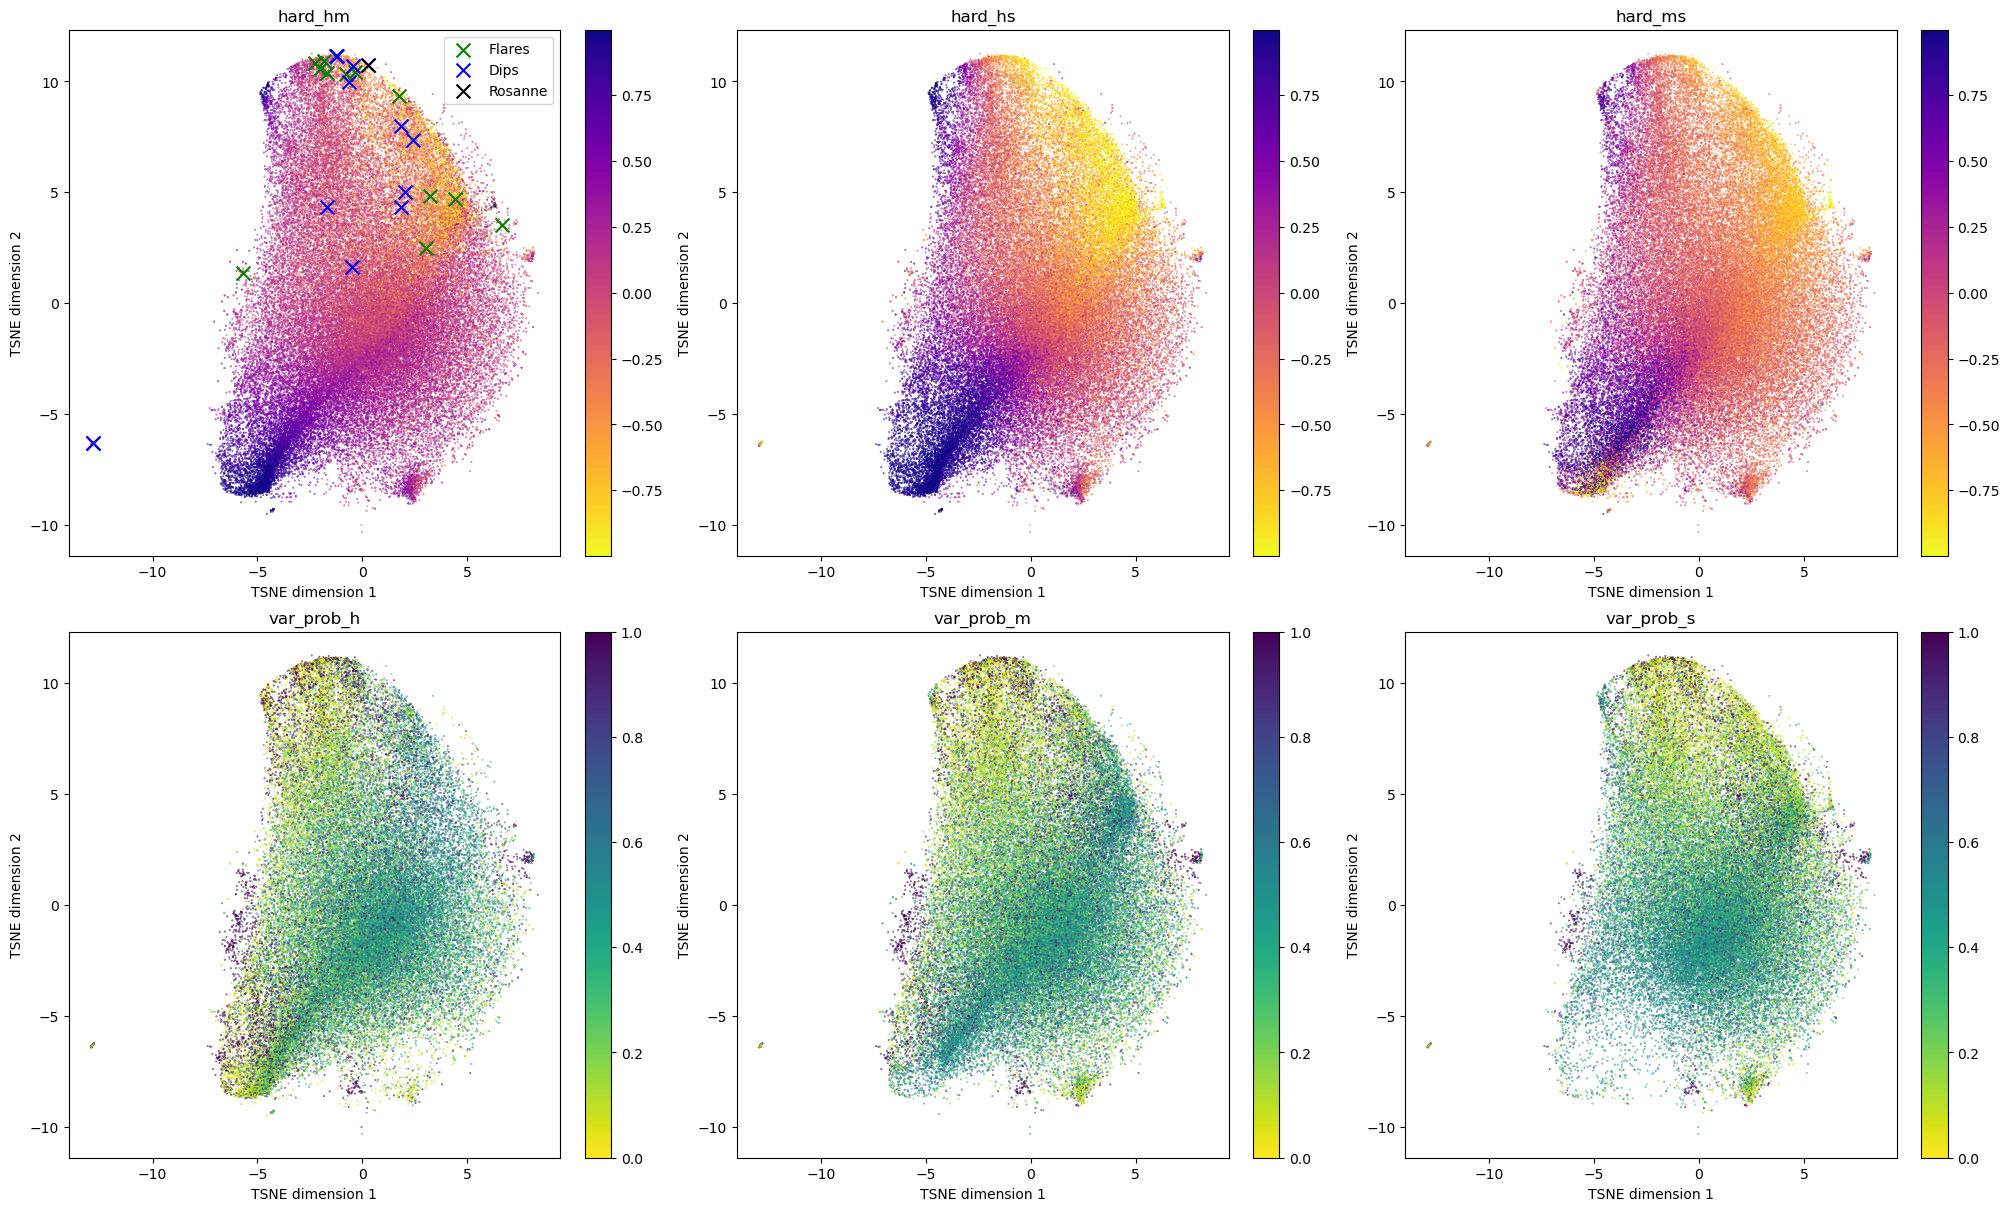

In [94]:
# Load the DataFrame from the CSV file
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Plot
fig, axs = plt.subplots(2, 3, figsize=(20, 12),constrained_layout = True)
colourmap_hard = 'plasma_r'
colourmap_var = 'viridis_r'

hard_hm = axs[0,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'],c=df_properties['hard_hm'], s=0.1, cmap=colourmap_hard)
axs[0,0].set_xlabel('TSNE dimension 1')
axs[0,0].set_ylabel('TSNE dimension 2')
axs[0,0].set_title(f'hard_hm')
fig.colorbar(hard_hm, ax = axs[0,0])

hard_hs = axs[0,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_hs'], s=0.1, cmap=colourmap_hard)
axs[0,1].set_xlabel('TSNE dimension 1')
axs[0,1].set_ylabel('TSNE dimension 2')
axs[0,1].set_title(f'hard_hs')
fig.colorbar(hard_hs, ax = axs[0,1])

hard_ms = axs[0,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['hard_ms'], s=0.1, cmap=colourmap_hard)
axs[0,2].set_xlabel('TSNE dimension 1')
axs[0,2].set_ylabel('TSNE dimension 2')
axs[0,2].set_title(f'hard_ms')
fig.colorbar(hard_ms, ax = axs[0,2])

var_h = axs[1,0].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_h'], s=0.1, cmap=colourmap_var)
axs[1,0].set_xlabel('TSNE dimension 1')
axs[1,0].set_ylabel('TSNE dimension 2')
axs[1,0].set_title(f'var_prob_h')
fig.colorbar(var_h, ax = axs[1,0])

var_m = axs[1,1].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_m'], s=0.1, cmap=colourmap_var)
axs[1,1].set_xlabel('TSNE dimension 1')
axs[1,1].set_ylabel('TSNE dimension 2')
axs[1,1].set_title(f'var_prob_m')
fig.colorbar(var_m, ax = axs[1,1])

var_s = axs[1,2].scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_properties['var_prob_s'], s=0.1, cmap=colourmap_var)
axs[1,2].set_xlabel('TSNE dimension 1')
axs[1,2].set_ylabel('TSNE dimension 2')
axs[1,2].set_title(f'var_prob_s')
fig.colorbar(var_s, ax = axs[1,2])

for ax in axs.flatten()[0:1]:
    ax.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='green', marker='x', s=100, label='Flares')
    ax.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=100, label='Dips')
    ax.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='black', marker='x', s=100, label='Rosanne')
    ax.legend()

plt.show()